Импортирование всех библиотек

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [9]:
# чтение данных из файла reviews.csv с использованием точки с запятой в качестве разделителя
data = pd.read_csv("reviews.csv", delimiter=";")

# вывод информации о структуре
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8343 entries, 0 to 8342
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Идентификатор  8343 non-null   object 
 1   Оценка         8248 non-null   float64
 2   Комментарий    8343 non-null   object 
dtypes: float64(1), object(2)
memory usage: 195.7+ KB


Нормальзация данных

In [10]:
# удаление столбца Идентификатор
data.drop(columns=['Идентификатор'], inplace=True)

# вывод первых нескольких строк
data.head()

Оценка                                        Комментарий
0     1.0  Мошенники! Не связывайтесь с ними! Вечером нак...
1     1.0  Если оплатили деньги за путёвку, но изменились...
2     3.7  Этот отель мы выбрали, поскольку был опыт отли...
3    10.0  Это был мой лучший отдых, благодаря этой компа...
4    10.0  Отличная компания для организации отдыха в ОАЭ...

In [11]:
# удаление строк с отсутствующими значениями в столбце Оценка
data = data.dropna(subset=["Оценка"])

# удаление строк с отсутствующими значениями в столбце Комментарий
data = data.dropna(subset=["Комментарий"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8248 entries, 0 to 8342
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Оценка       8248 non-null   float64
 1   Комментарий  8248 non-null   object 
dtypes: float64(1), object(1)
memory usage: 193.3+ KB


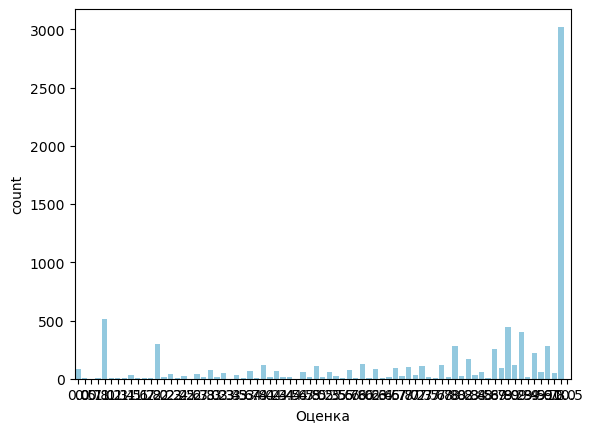

In [12]:
sns.countplot(x='Оценка', data=data, color='skyblue');

Оценки 10.0 очень много уберем половину

In [14]:
data10 = data[data['Оценка'] == 10].sample(frac=0.5, random_state=42)
data = data.drop(data10.index)

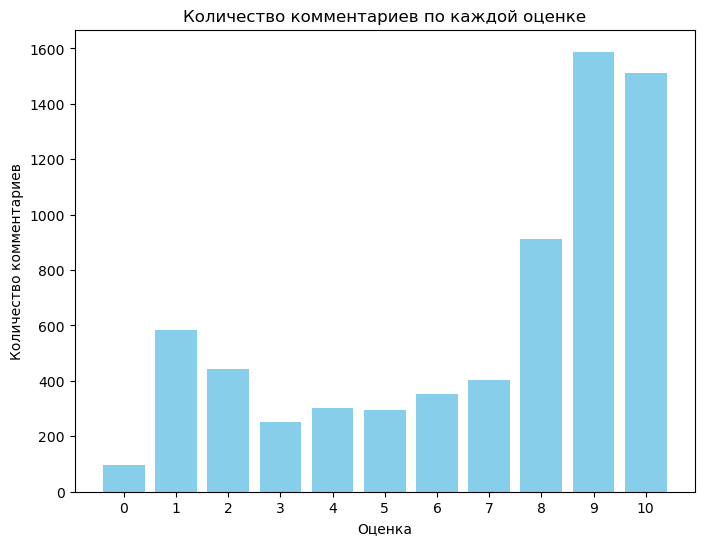

In [15]:
# преобразуем столбец 'Оценка' к целочисленному типу данных
data['Оценка'] = data['Оценка'].astype(int)

# группируем данные по оценкам и подсчитываем количество комментариев для каждой оценки
comments_by_rating = data['Оценка'].value_counts().sort_index()

# создаем график
plt.figure(figsize=(8, 6))
plt.bar(comments_by_rating.index, comments_by_rating.values, color='skyblue')
plt.xlabel('Оценка')
plt.ylabel('Количество комментариев')
plt.title('Количество комментариев по каждой оценке')
plt.xticks(comments_by_rating.index)
plt.show()

У меня есть оценки  3.1, 4.3, 0.1
Это очень много. Округлю оценнки и удалю нулевые оценки для удобства.

In [16]:
# округляем столбец 'Оценка' до целых чисел
data['Оценка'] = data['Оценка'].round().astype(int)
# удаляем строки, в которых оценка равна нулю
data = data.query('Оценка != 0')

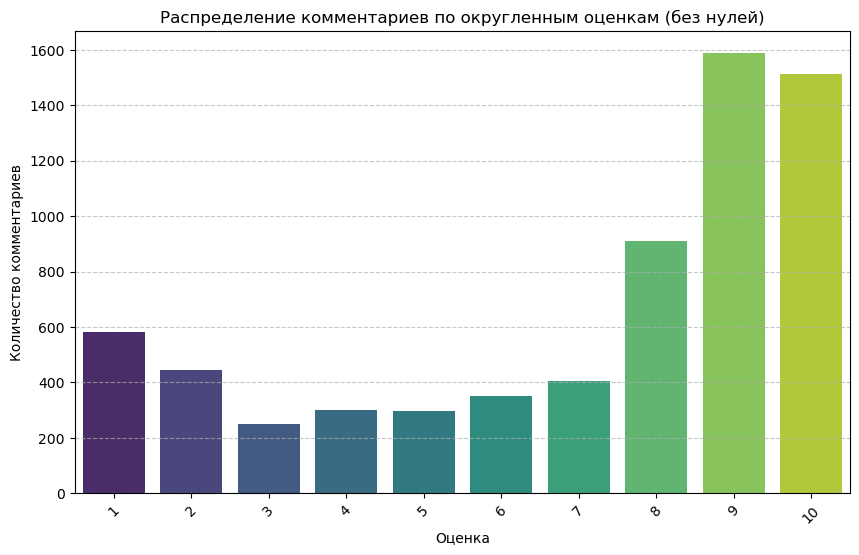

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Оценка', palette='viridis')
plt.xlabel('Оценка')
plt.ylabel('Количество комментариев')
plt.title('Распределение комментариев по округленным оценкам (без нулей)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# подсчитываем количество оценок каждого значения
count_by_rating = data['Оценка'].value_counts().sort_index()

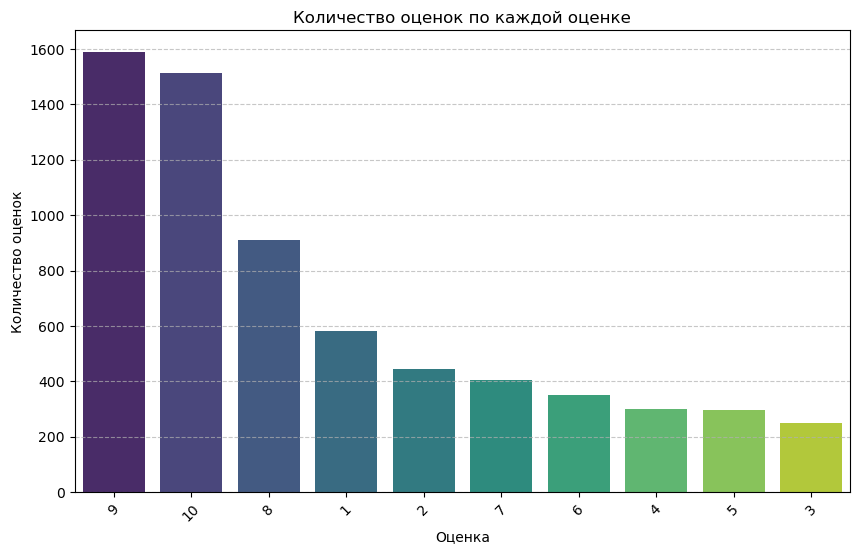

In [19]:
# Создаем график
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Оценка', palette='viridis', order=data['Оценка'].value_counts().index)
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.title('Количество оценок по каждой оценке')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
# сбрасываем индекс DataFrame, чтобы начать с 0 и иметь более структурированный индекс
data = data.reset_index()

# удаляем столбец "index", который может быть лишним после сброса индекса
data = data.drop(columns="index")

Для создания облака часто встречающихся слов (или Word Cloud) из комментариев, а также для деления на негативные и позитивные комментарии, мы сначала должны провести лемматизацию и анализ тональности комментариев.

In [21]:
# объединение все комментарии в одну строку
all_comments = " ".join(data['Комментарий'])

In [22]:
# инициализация лемматизатора и стоп-слов
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words("russian"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# фнкция для лемматизации текста и удаления стоп-слов
def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word.lower() not in stop_words]
    return " ".join(words)

In [24]:
all_comments = preprocess_text(all_comments)

# Word Cloud для всех комментариев
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

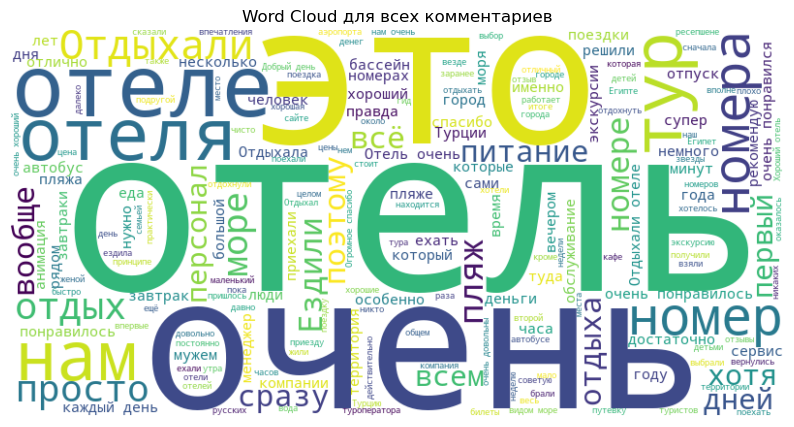

In [25]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud для всех комментариев')
plt.show()

Пусть негативные отзывы это оценки 1 2 3 4


Нейтральные отзывы 5 6 7


И положительные отзывы 8 9 10

In [26]:
data['Лемматизированный_комментарий'] = data['Комментарий'].apply(preprocess_text)

In [27]:
# функция для классификации отзывов на негативные, нейтральные и положительные
def classify_review(rating):
    if rating in [1, 2, 3, 4]:
        return 'Негативный'
    elif rating in [5, 6, 7]:
        return 'Нейтральный'
    else:
        return 'Положительный'

In [28]:
data['Тип_отзыва'] = data['Оценка'].apply(classify_review)

In [29]:
# Word Cloud для негативных отзывов
negative_reviews = " ".join(data[data['Тип_отзыва'] == 'Негативный']['Лемматизированный_комментарий'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Word Cloud для нейтральных отзывов
neutral_reviews = " ".join(data[data['Тип_отзыва'] == 'Нейтральный']['Лемматизированный_комментарий'])
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)

# Word Cloud для положительных отзывов
positive_reviews = " ".join(data[data['Тип_отзыва'] == 'Положительный']['Лемматизированный_комментарий'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

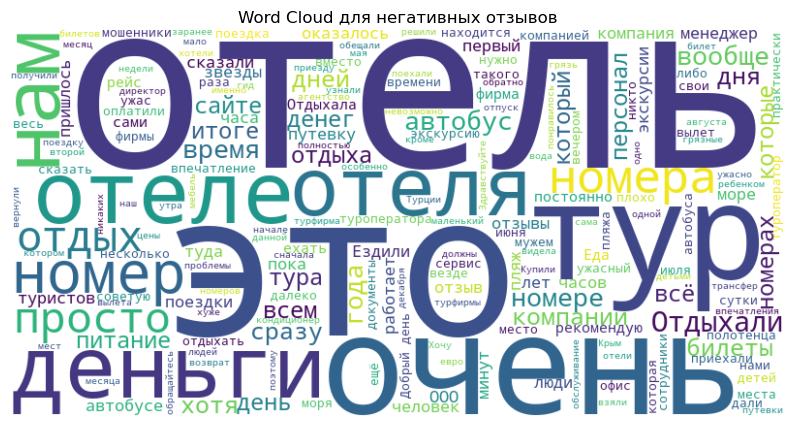

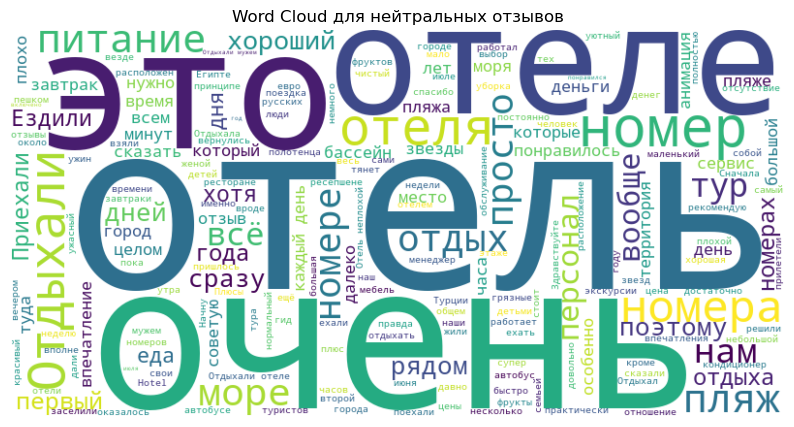

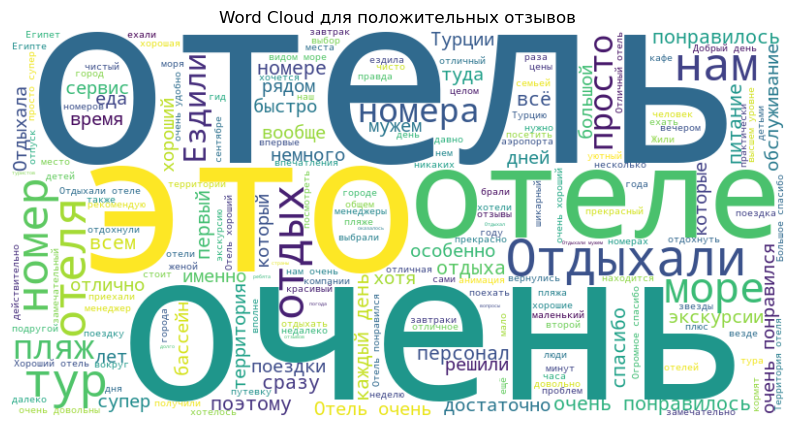

In [30]:
# для негативных отзывов
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud для негативных отзывов')
plt.show()

# для нейтральных отзывов
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud для нейтральных отзывов')
plt.show()

# для положительных отзывов
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud для положительных отзывов')
plt.show()

In [31]:
data.head()

Оценка                                        Комментарий  \
0       1  Мошенники! Не связывайтесь с ними! Вечером нак...   
1       1  Если оплатили деньги за путёвку, но изменились...   
2       3  Этот отель мы выбрали, поскольку был опыт отли...   
3      10  Отличная компания для организации отдыха в ОАЭ...   
4      10  Хочу поделиться о "Центре оздоровления и реаби...   

                       Лемматизированный_комментарий     Тип_отзыва  
0  Мошенники связывайтесь ними Вечером накануне о...     Негативный  
1  оплатили деньги путёвку изменились планы либо ...     Негативный  
2  отель выбрали поскольку опыт отличного отдыха ...     Негативный  
3  Отличная компания организации отдыха ОАЭ Точно...  Положительный  
4  Хочу поделиться Центре оздоровления реабилитац...  Положительный

**Использование лемматизированного текста для обучения:**

*Преимущества:*
1. **Уменьшение размерности:** Лемматизация может снизить размерность данных, поскольку слова будут представлены в более общей форме, что может улучшить производительность модели и сократить требуемое количество данных для обучения.
2. **Снижение шума:** Лемматизация может устранить различные формы слова, что помогает снизить шум в данных и сделать их более консистентными.
3. **Улучшение обобщающей способности:** За счет сокращения форм слова, модель может лучше обобщать изученные закономерности на новых данных.

*Недостатки:*
1. **Потеря информации:** В процессе лемматизации теряется некоторая информация, такая как грамматическая форма слова, которая может быть важной для определенных задач.
2. **Слова-независимые**: Лемматизация может сделать некоторые слова абсолютно независимыми друг от друга, что может быть не всегда желательно.

**Использование оригинального комментария для обучения:**

*Преимущества:*
1. **Сохранение контекста:** Оригинальные комментарии сохраняют контекст и специфику форм слов, что может быть полезным для задач, требующих сохранения этой информации.
2. **Потенциально более точные результаты:** В некоторых случаях, особенно если ваша задача требует точной обработки слов, использование оригинальных комментариев может быть предпочтительным.

*Недостатки:*
1. **Увеличение размерности:** Оригинальные комментарии могут быть более многословными и иметь большую размерность, что может потребовать больше вычислительных ресурсов для обучения моделей.
2. **Шум и нерегулярности:** Оригинальные данные могут содержать опечатки, грамматические ошибки и другие нерегулярности, которые могут усложнить анализ.

В моем случае, для обучения моделей на отзывах, лемматизированный текст, скорее всего, является предпочтительным вариантом.

In [32]:
# векторизатор текста
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # максимальное количество признаков (слов)

In [33]:
# матрица TF-IDF для текста комментариев
X = tfidf_vectorizer.fit_transform(data['Лемматизированный_комментарий'])
y = data['Оценка']

In [34]:
# обучающий и тестовый наборы в соотношении 8 к 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# модель Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
# модель Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [37]:
# модель Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# оценка производительности моделей
y_pred_lr = lr_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("Оценка производительности модели Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}\n")

print("Оценка производительности модели Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}\n")

print("Оценка производительности модели Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}\n")

Оценка производительности модели Logistic Regression:
              precision    recall  f1-score   support

           1       0.49      0.57      0.52       125
           2       0.26      0.16      0.20        89
           3       0.33      0.02      0.03        55
           4       0.11      0.02      0.04        48
           5       0.33      0.02      0.03        59
           6       0.00      0.00      0.00        65
           7       0.27      0.05      0.09        74
           8       0.24      0.18      0.21       197
           9       0.29      0.51      0.37       293
          10       0.46      0.61      0.52       323

    accuracy                           0.36      1328
   macro avg       0.28      0.21      0.20      1328
weighted avg       0.32      0.36      0.31      1328

Accuracy: 0.3569277108433735

Оценка производительности модели Naive Bayes:
              precision    recall  f1-score   support

           1       0.55      0.55      0.55       125
  

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# матрицы ошибок 
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=np.arange(1, 11))
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=np.arange(1, 11))
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=np.arange(1, 11))

In [40]:
# Создайте функцию для визуализации матрицы ошибок
def plot_confusion_matrix_colorful(cm, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=False, square=True, xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 11))
    plt.xlabel('Предсказанные оценки')
    plt.ylabel('Истинные оценки')
    plt.title(f'Матрица ошибок для модели {model_name}')
    plt.show()

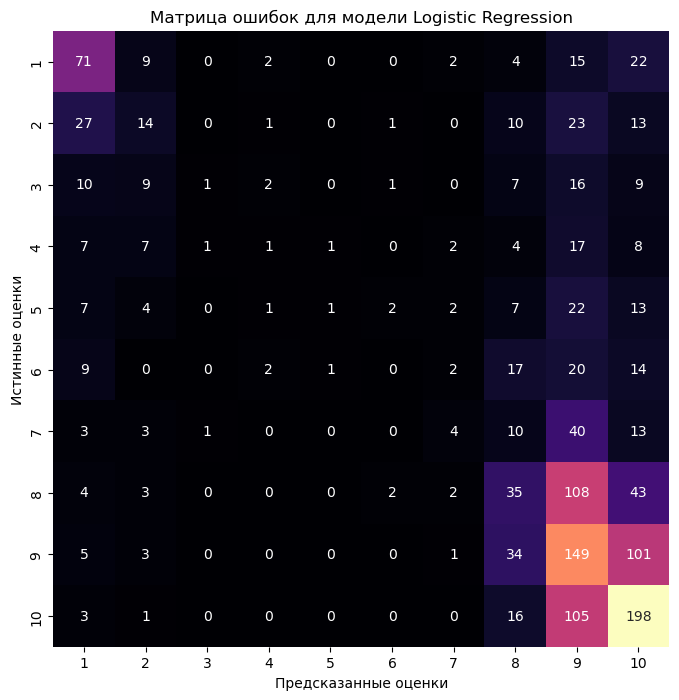

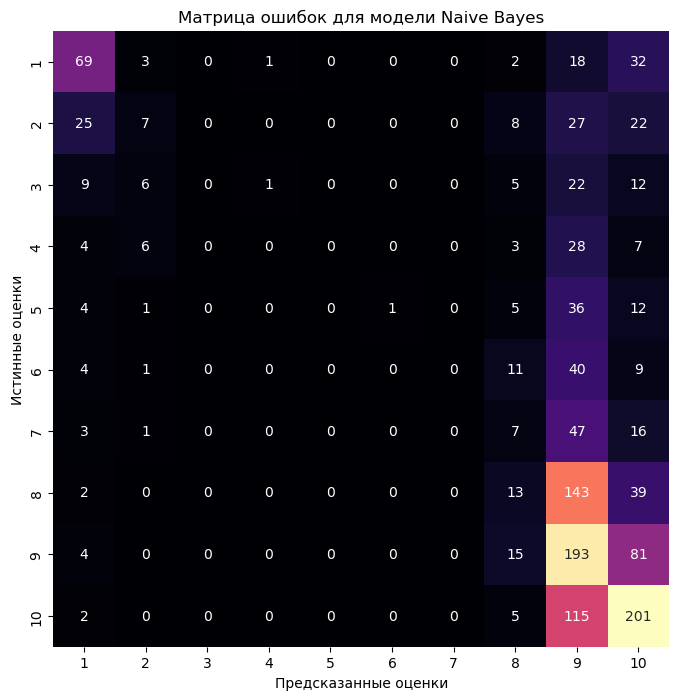

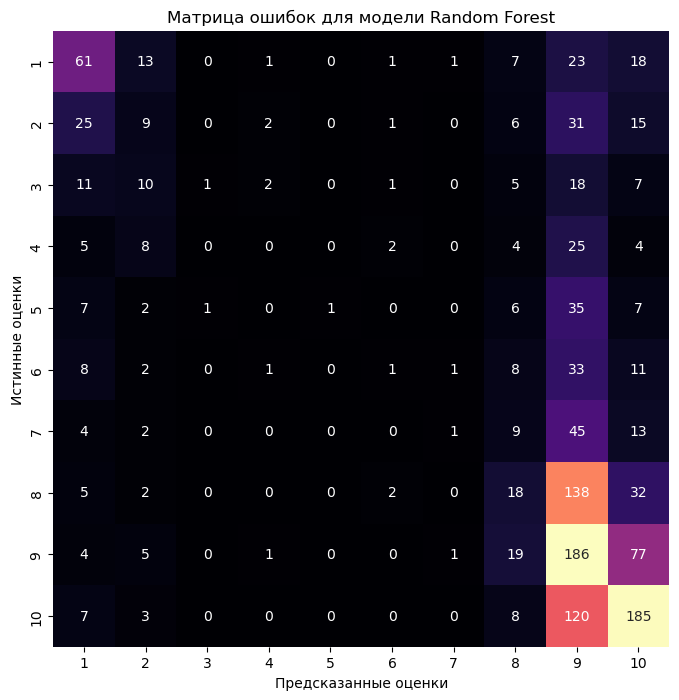

In [41]:
# Визуализируйте матрицу ошибок для модели Logistic Regression
plot_confusion_matrix_colorful(cm_lr, 'Logistic Regression')

# Визуализируйте матрицу ошибок для модели Naive Bayes
plot_confusion_matrix_colorful(cm_nb, 'Naive Bayes')

# Визуализируйте матрицу ошибок для модели Random Forest
plot_confusion_matrix_colorful(cm_rf, 'Random Forest')

In [33]:
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

# MultinomialNB не имеет множества гиперпараметров для настройки

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# объекты GridSearchCV для каждой модели
lr_grid_search = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Grid Search для каждой модели на обучающих данных
lr_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)

# наилучшие параметры для каждой модели
best_lr_params = lr_grid_search.best_params_
best_rf_params = rf_grid_search.best_params_

# производительность моделей с наилучшими параметрами на тестовых данных
best_lr_model = LogisticRegression(**best_lr_params)
best_rf_model = RandomForestClassifier(**best_rf_params)

best_lr_model.fit(X_train, y_train)
best_rf_model.fit(X_train, y_train)

y_pred_best_lr = best_lr_model.predict(X_test)
y_pred_best_rf = best_rf_model.predict(X_test)

# отчеты о классификации и точности для обновленных моделей
print("Лучшая модель Logistic Regression:")
print(classification_report(y_test, y_pred_best_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_lr)}\n")

print("Лучшая модель Random Forest:")
print(classification_report(y_test, y_pred_best_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf)}\n")


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Лучшая модель Logistic Regression:
              precision    recall  f1-score   support

           1       0.53      0.46      0.50       121
           2       0.34      0.15      0.20        96
           3       0.00      0.00      0.00        52
           4       0.50      0.06      0.11        62
           5       0.00      0.00      0.00        58
           6       0.16      0.05      0.07        64
           7       0.29      0.03      0.05        72
           8       0.21      0.14      0.17       167
           9       0.30      0.32      0.31       332
          10       0.51      0.81      0.62       607

    accuracy                           0.43      1631
   macro avg       0.28      0.20      0.20      1631
weighted avg       0.37      0.43      0.37      1631

Accuracy: 0.43041079092581236

Лучшая модель Random Forest:
              precision    recall  f1-score   support

           1       0.49      0.33      0.40       121
           2       0.35      0.14    

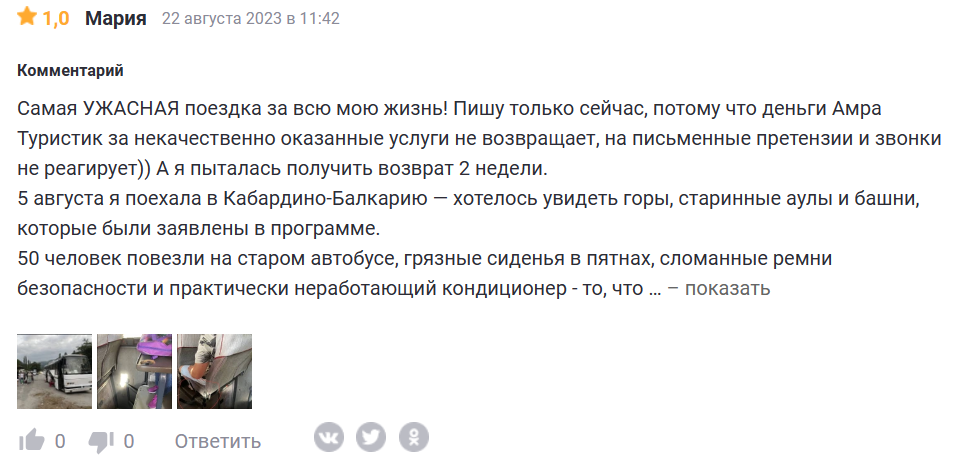

In [42]:
your_review_text = """
Самая УЖАСНАЯ поездка за всю мою жизнь! Пишу только сейчас, потому что деньги Амра Туристик за некачественно оказанные услуги не возвращает, на письменные претензии и звонки не реагирует )) А я пыталась получить возврат 2 недели.
5 августа я поехала в Кабардино-Балкарию - хотелось увидеть горы, старинные аулы и башни, которые были заявлены в программе.
50 человек повезли на старом автобусе, грязные сиденья в пятнах, сломанные ремни безопасности и практически неработающий кондиционер - то, что нужно за наши деньги!
В итоге при подъеме в горы в районе 13 часов дня автобус сломался. Как сказала гид - ну жарко же. А зачем на непригодной для подъема в горы технике везти людей? Мы простояли на обочине трассы в жару +38 почти 2 часа, пока сотрудник компании пыталась созвониться с Амра Туристик.
В итоге в горы мы не поднялись, никаких аулов и башен не увидели, спустились к озеру в кафе, пока нам продолжали искать автобус для возвращения в Краснодар. Ок, нашли автобус, позвали забирать вещи - внимание, и мы еще 2 часа просидели у обочины! Потому что автобус все еще «сейчас приедет».
Итого - я не увидела то, ради чего ехала 9 часов в одну сторону, заявленная программа не была выполнена со стороны туроператора, я провела 4 часа на обочине дороге - отличная экскурсия, Я ПЛАТИЛА НЕ ЗА ЭТО! Амра Туристик даже извинения не принесла, никакой компенсации предложено не было! И мои требования о возврате средств они игнорируют. При этом деньги принимают на карту физ лица (хотя это ООО) и наличкой в автобусе, чеки не выдают.
Кстати, в нашем автобусе были люди, которые должны были ехать в Адыгею, но им отменили поездку, т.к. сломался автобус. Видимо, этот автобус в итоге повез нас ????
Отвратительная компания, надеюсь, вы скоро закроетесь с учетом такого отношения к клиентам!
"""

In [43]:
your_review_processed = preprocess_text(your_review_text)  # Здесь preprocess_text() - ваша функция предобработки

In [44]:
# Векторизируйте ваш отзыв
your_review_vectorized = tfidf_vectorizer.transform([your_review_processed])

In [45]:
# Предскажите оценку с помощью каждой модели
lr_prediction = lr_model.predict(your_review_vectorized)
nb_prediction = nb_model.predict(your_review_vectorized)
rf_prediction = rf_model.predict(your_review_vectorized)

In [46]:
# Выведите предсказанные оценки
print(f"Предсказанная оценка (Logistic Regression): {lr_prediction[0]}")
print(f"Предсказанная оценка (Naive Bayes): {nb_prediction[0]}")
print(f"Предсказанная оценка (Random Forest): {rf_prediction[0]}")

Предсказанная оценка (Logistic Regression): 1
Предсказанная оценка (Naive Bayes): 1
Предсказанная оценка (Random Forest): 1


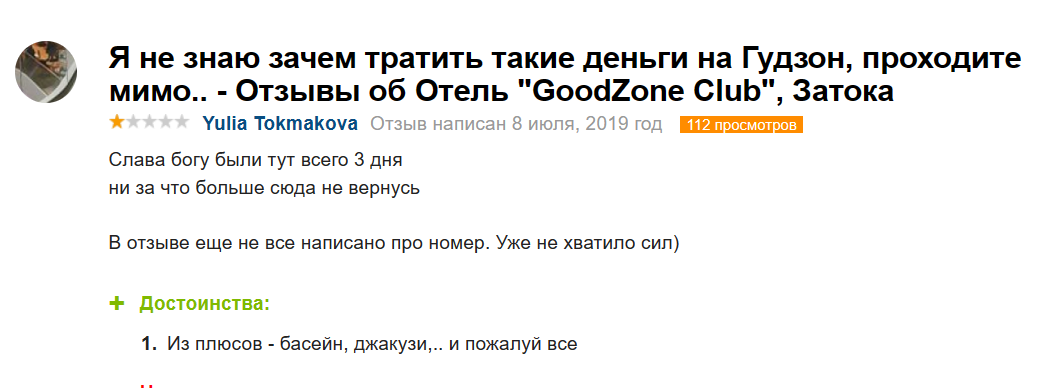

In [47]:
your_review_text = """
Я не знаю зачем тратить такие деньги на Гудзон, 
проходите мимо.. - Отзывы об Отель "GoodZone Club", 
Затока Слава богу были тут всего 3 дня
ни за что больше сюда не вернусь 
В отзыве еще не все написано про номер. Уже не хватило сил)
Из плюсов - басейн, джакузи,.. и пожалуй все
"""

In [48]:
your_review_processed = preprocess_text(your_review_text)  # Здесь preprocess_text() - ваша функция предобработки

In [49]:
# Векторизируйте ваш отзыв
your_review_vectorized = tfidf_vectorizer.transform([your_review_processed])

In [50]:
# Предскажите оценку с помощью каждой модели
lr_prediction = lr_model.predict(your_review_vectorized)
nb_prediction = nb_model.predict(your_review_vectorized)
rf_prediction = rf_model.predict(your_review_vectorized)

In [51]:
# Выведите предсказанные оценки
print(f"Предсказанная оценка (Logistic Regression): {lr_prediction[0]}")
print(f"Предсказанная оценка (Naive Bayes): {nb_prediction[0]}")
print(f"Предсказанная оценка (Random Forest): {rf_prediction[0]}")

Предсказанная оценка (Logistic Regression): 2
Предсказанная оценка (Naive Bayes): 9
Предсказанная оценка (Random Forest): 1
